# Neural Network from Scratch in TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper_utils as utils
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

# Initializing Neural Network

In [2]:
# Assumed neural layers are densly connected
# Constructed for a classfication Task 
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        # Weights and Biases
        self.W = {}
        self.b = {}
        
        # Gradients of Weights and Biases
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
        
        for i in range(1, self.L) :
            # set initial random values for weight
            # shape is number of nodes in current layer by the previous layer
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])))
            
             # set initial random values for biases
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1)))

# Forward Pass

In [3]:
# Extending Class for ease
class NeuralNetwork(NeuralNetwork):
    
    # X is batch of inputs fed
    def forward_pass(self, X):
        # Transformation done because X is part of a batch        
        A = tf.convert_to_tensor(X, dtype=tf.float32)
        for i in range(1, self.L):
            # Matrix multiplication            
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i]) 
            
            # Apply relu for all layers except last layer
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                # Just a linear sum                
                A = Z
        return A

# Computing Loss and Updating Parameters

In [4]:
class NeuralNetwork(NeuralNetwork):
    
    # A - Linear output to be fedto activation
    # Y - true labels
    def compute_loss(self, A, Y):
        # loss on the batch
        loss = tf.nn.softmax_cross_entropy_with_logits(Y, A)
        return tf.reduce_mean(loss)
    
    # lr - learnng rate
    def update_params(self, lr):
        for i in range(1, self.L):
            # Adjust weights in back prop
            self.W[i].assign_sub(lr * self.dW[i])
            
            # Adjust biases in back prop
            self.b[i].assign_sub(lr * self.db[i])
            

# Predict and Info Functions

In [5]:
class NeuralNetwork(NeuralNetwork):
    
    # Predict a given input
    def predict(self, X):
        A = self.forward_pass(X)
        predictions =  tf.nn.softmax(A)
        return tf.argmax(predictions, axis=1)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

# Training on Batch

In [6]:
class NeuralNetwork(NeuralNetwork):
    
    # forward pass , with backward prop
    # lr - learning rate
    def train_on_batch(self, X, Y, lr):
        
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
            
        for key in self.W.keys():
            # Set gradients of weights and biases
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        
        # delete tape
        del tape
          
        # update parameters     
        self.update_params(lr)
        
        # return loss
        return loss.numpy()

# Training on Complete Set

In [17]:
class NeuralNetwork(NeuralNetwork):
    
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        
        # A history object
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': [],
        }
        
        for e in range(0, epochs):
            epoch_train_loss = 0
            print("Epoch {}".format(e), end=".")
            for i in range(0 ,steps_per_epoch):
                #  Breaking into batches               
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
            
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            
            # calculate loss
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)
            
            val_preds = self.predict(x_test)
            
            # validation accuraccy
            val_acc = np.mean(np.argmax(y_test, axis=1) == val_preds.numpy())
            
            history['val_acc'].append(val_acc) 
            
            print('Validation Accuracy: ', val_acc)
            
        return history

# Application

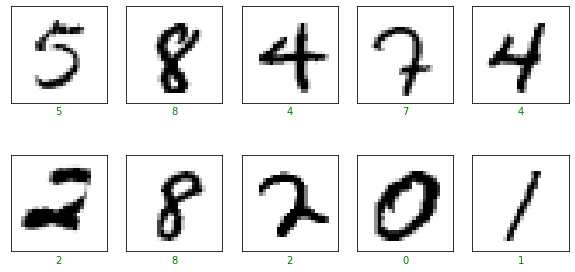

In [18]:
# Loads MNIST DataSet

(x_train, y_train), (x_test, y_test) = utils.load_data()

utils.plot_random_examples(x_train, y_train).show()

In [19]:
# two hidden layers
net = NeuralNetwork([784, 128, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [22]:
batch_size= 120
epochs = 15
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3
print('Steps per epoch: ', steps_per_epoch)

Steps per epoch:  500


In [23]:
history = net.train(
    x_train,
    y_train,
    x_test,
    y_test,
    epochs,
    steps_per_epoch,
    batch_size,
    lr
)

Epoch 0...........Validation Accuracy:  0.8731
Epoch 1...........Validation Accuracy:  0.876
Epoch 2...........Validation Accuracy:  0.8787
Epoch 3...........Validation Accuracy:  0.8821
Epoch 4...........Validation Accuracy:  0.8834
Epoch 5...........Validation Accuracy:  0.8831
Epoch 6...........Validation Accuracy:  0.8826
Epoch 7...........Validation Accuracy:  0.8823
Epoch 8...........Validation Accuracy:  0.8834
Epoch 9...........Validation Accuracy:  0.8869
Epoch 10...........Validation Accuracy:  0.8856
Epoch 11...........Validation Accuracy:  0.887
Epoch 12...........Validation Accuracy:  0.8885
Epoch 13...........Validation Accuracy:  0.8892
Epoch 14...........Validation Accuracy:  0.8886


# Final Results

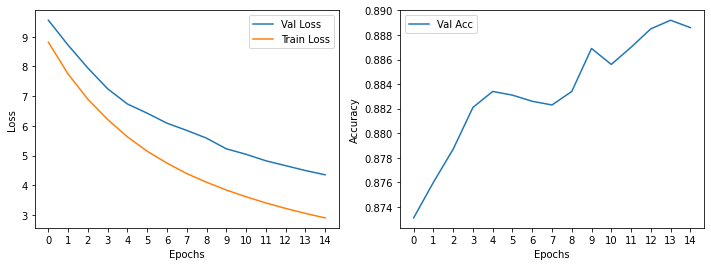

In [26]:
utils.plot_results(history).show()

In [27]:
preds = net.predict(x_test)

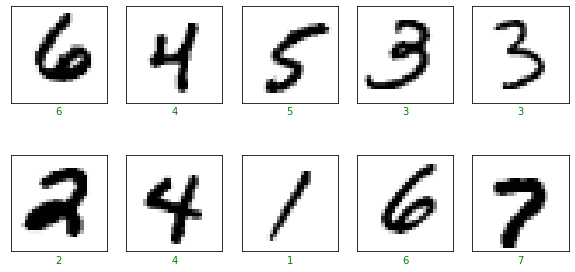

In [28]:
utils.plot_random_examples(x_test, y_test, preds.numpy()).show()